# Online GP updates
This notebooks looks into how a GP changes as more data is added in a simple 1D case.

In [16]:
from loguru import logger
from torch.utils.data import DataLoader, TensorDataset
from botorch.models.gpytorch import GPyTorchModel
from botorch import fit_gpytorch_mll
import torch
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO, DeepApproximateMLL

# Function to fit an exact GP model
def fit_exact_gp_model(gp):
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

# Function to fit a variational GP model
def fit_variational_gp(model: GPyTorchModel,
                       train_x: torch.tensor,
                       train_y: torch.tensor,  # IMPORTANT, train_y should be (, N) shaped.
                       batch_size=64,  # Probably because train_y.numel() (?)
                       num_epochs=15,
                       learning_rate=0.01,
                       logging=False,
                       deep=False) -> None:
    model.train()
    train_y = train_y.squeeze(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # The loss of variational GP is an ELBO one like Gaussian NN.
    if deep:
        mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_y.numel()))
    else:
        mll = VariationalELBO(model.likelihood, model.model, train_y.numel())
    train_loader = DataLoader(TensorDataset(train_x, train_y),
                              batch_size=batch_size,
                              shuffle=True)

    for _ in range(num_epochs):
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)

            loss = -mll(output, y_batch).mean()  # mean() necessary?
            loss.backward()

            if logging:
                logger.debug(f"variational loss {loss}")

            optimizer.step()

    model.eval()


# Function to update the GP model with new data
def update_gp_model(gp, new_x, new_y):
    return gp.condition_on_observations(X=new_x, Y=new_y).double()


# Function to plot the data and predictions
def plot_gp(gp, train_x, train_y, new_x, new_y, title):
    gp.eval()
    with torch.no_grad():
        test_x = torch.linspace(0, 1, 100).unsqueeze(-1)
        posterior = gp.posterior(test_x)
        mean = posterior.mean.squeeze(-1)
        lower, upper = posterior.mvn.confidence_region()

    plt.figure(figsize=(10, 6))
    plt.plot(test_x.numpy(), mean.numpy(), 'b')
    plt.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    plt.scatter(train_x.numpy(), train_y.numpy(), c='r', s=50, zorder=10)
    if new_x is not None and new_y is not None:
        plt.scatter(new_x.numpy(), new_y.numpy(), c='g', s=50, zorder=10)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Mean', '95% CI', 'Initial Data', 'New Data'])
    plt.show()


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0450], dtype=torch.float64), std = tensor([0.5647], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


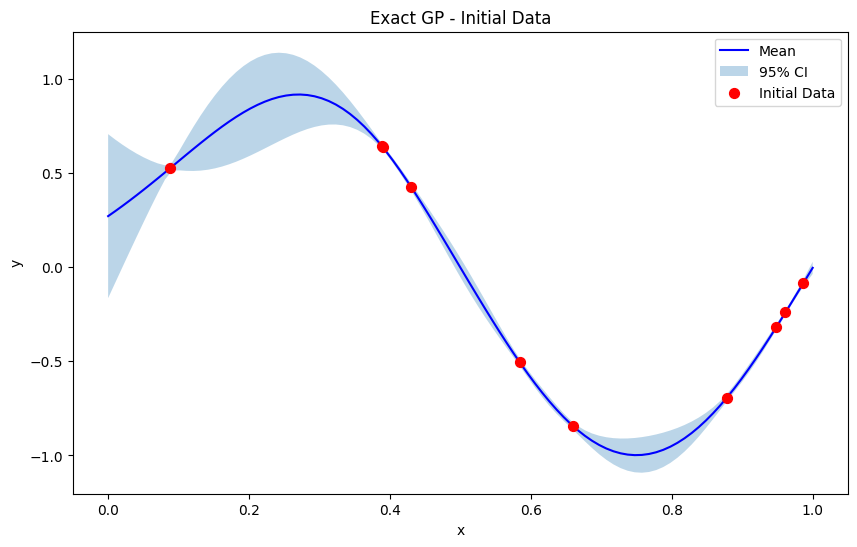

/tmp/ipykernel_15730/487456197.py:57: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  return gp.condition_on_observations(X=new_x, Y=new_y).double()
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/gpytorch.py:500: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  fantasy_model = super().condition_on_observations(X=inputs, Y=targets, **kwargs)


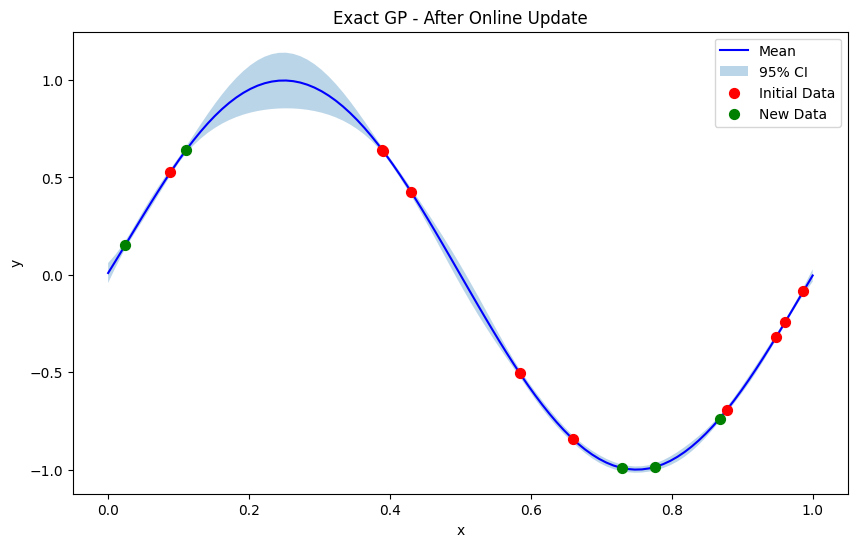

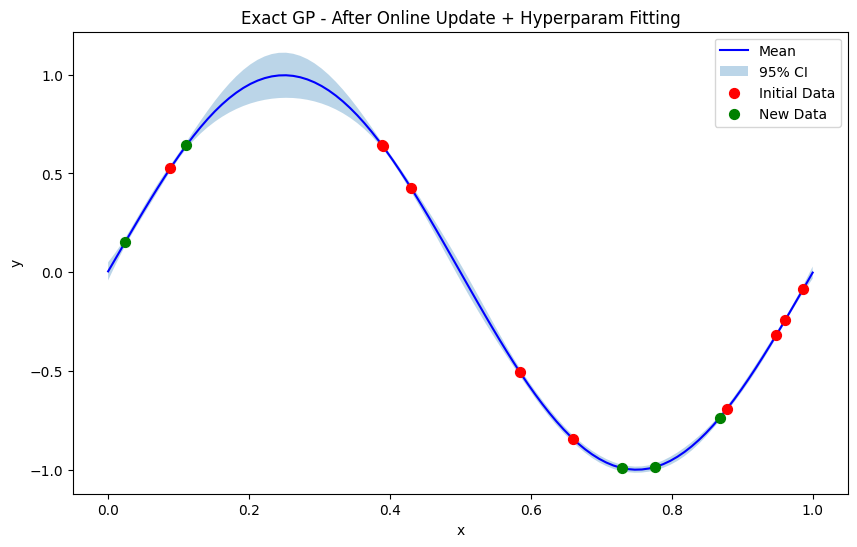

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.1579], dtype=torch.float64), std = tensor([0.6242], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


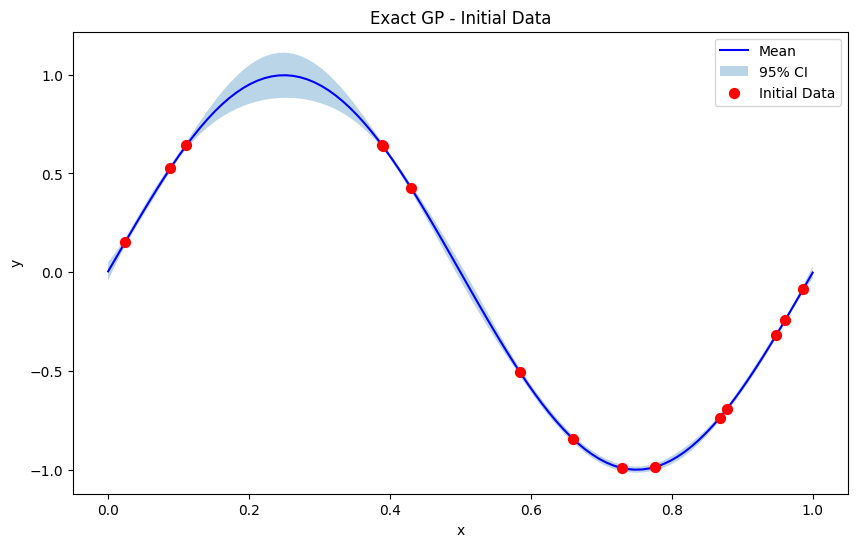

In [18]:
# Initial Data
train_x = torch.rand(10, 1, dtype=torch.double)  # 10 initial training points
train_y = torch.sin(train_x * (2 * torch.pi))  # initial target values

# New Data for Online Updates
new_x = torch.rand(5, 1)  # new data points
new_y = torch.sin(new_x * (2 * torch.pi))  # new target values

# Exact GP Model
gp = SingleTaskGP(train_x, train_y)
fit_exact_gp_model(gp)
plot_gp(gp, train_x, train_y, None, None, "Exact GP - Initial Data")
gp = update_gp_model(gp, new_x, new_y)
plot_gp(gp, train_x, train_y, new_x, new_y, "Exact GP - After Online Update")
fit_exact_gp_model(gp)
plot_gp(gp, train_x, train_y, new_x, new_y, "Exact GP - After Online Update + Hyperparam Fitting")

"""
# Variational GP Model
vgp = SingleTaskVariationalGP(train_x, train_y)
fit_variational_gp(vgp, train_x, train_y, logging=True)
plot_gp(vgp, train_x, train_y, None, None, "Variational GP - Initial Data")
vgp = update_gp_model(vgp, new_x, new_y)
plot_gp(vgp, train_x, train_y, new_x, new_y, "Variational GP - After Online Update")
"""

train_x2 = torch.cat([train_x, new_x])
train_y2 = torch.cat([train_y, new_y])
gp2 = SingleTaskGP(train_x2, train_y2)
fit_exact_gp_model(gp2)
plot_gp(gp2, train_x2, train_y2, None, None, "Exact GP - Without Online Updating")